In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

from scipy.stats import entropy
from sklearn.utils import shuffle

# Skew tent map
def skew_tent_map(omega=0.1847, x0=.5, n=2**15):
    x = np.zeros(n)
    x[0] = x0
    for i in range(1, len(x)):
        if x[i - 1] < omega:
            x[i] = x[i - 1] / omega
        else:
            x[i] = (1 - x[i - 1]) / (1 - omega)
    return x

# Logistic map
def logistic_map(n=2**15, r=4, x0=.4):
    x = np.zeros(n)
    x[0] = x0
    for i in range(n-1):
        x[i+1] = r*x[i]*(1-x[i])
    return x
# Schuster's map
def schuster_map(n=2**15, z=2, x0=.5):
    z = float(z)
    x = np.zeros(n)
    x[0] = x0
    for i in range(1, n):
        x[i], _ = np.modf(x[i-1] + x[i-1]**z)
    return x

# Henon map
def henon_map(n=1000000, a=1.4, b=0.3, x0=.4):
    x = np.zeros(n)
    x[0] = x0
    for i in range(1, len(x)):
        x[i] = 1 - a * x[i-1] ** 2 + b * x[i-1]
    return x

# Sine dataset (deterministic)
sine_data = np.sin(np.arange(0,1000,.01))

# Gaussian noise (stochastic)
gaussian_noise = np.random.normal(size=100000)

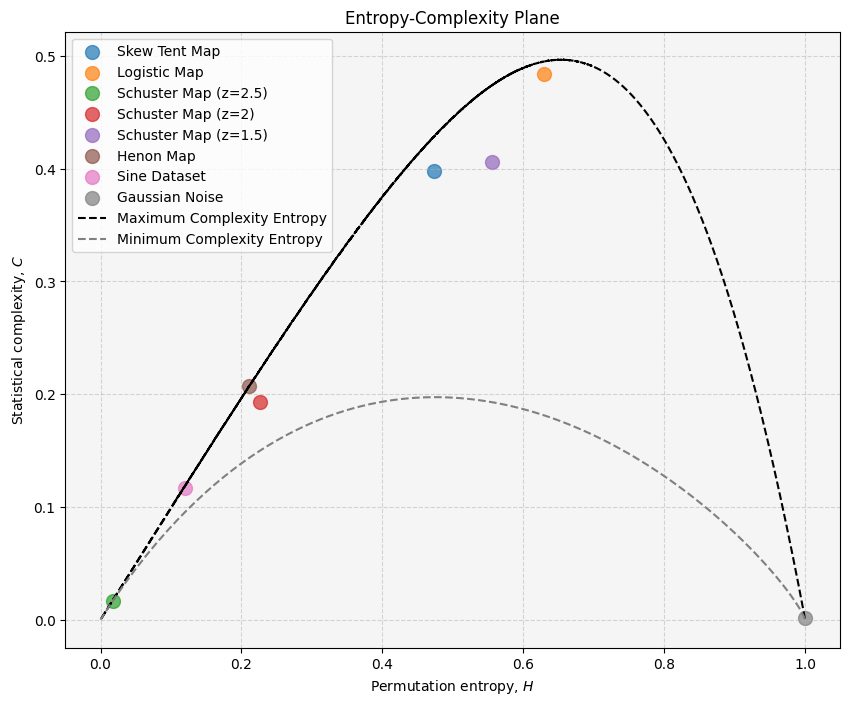

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt

def get_permutation_index(permutation):
    # Calculate the index of the permutation based on lexicographical order
    index = 0
    for pos in range(D - 1):
        cur = permutation[pos]
        for val in range(cur):
            check = True
            for pre in range(pos):
                if permutation[pre] == val:
                    check = False
            if check:
                index += math.factorial(D - pos - 1)
    return index

def map_permutation(lst):
    # Map the permutation into an index based on its lexicographical order
    sorted_index = [x[0] for x in sorted(enumerate(lst), key=lambda x: x[1])]
    return get_permutation_index(sorted_index)

def get_permutation_frequency(time_series):
    # Compute and return the frequency of each permutation in the given time series
    M = len(time_series)
    freq = [0] * N
    for i in range(M - D + 1):
        permutation_index = map_permutation(time_series[i: i + D])
        freq[permutation_index] += 1
    return freq

def shannon_entropy(prob):
    # Compute Shannon entropy of a probability distribution
    S = 0
    for p in prob:
        if p != 0:
            S -= p * math.log(p)
    return S

def hs(prob):
    # Compute the normalized Shannon entropy
    S_max = math.log(N)
    S = shannon_entropy(prob)
    return S / S_max

def qj(prob):
    # Compute the quadratic entropy based on the input probability distribution
    prob2 = [((p + 1 / N) / 2) for p in prob]
    S_max = math.log(N)
    S = shannon_entropy(prob)
    S2 = shannon_entropy(prob2)
    Q = Q0 * (S2 - S / 2 - S_max / 2)
    return Q

def cjs(prob):
    # Compute the complexity-entropy plane value based on the input probability distribution
    return hs(prob) * qj(prob)

def get_hs_and_cjs_for_timeseries(time_series):
    # Compute normalized Shannon entropy (hs) and complexity-entropy plane (cjs) for the given time series
    M = len(time_series)
    freq = get_permutation_frequency(time_series)
    prob = [f / (M - D + 1) for f in freq]
    return hs(prob), cjs(prob)

def generate_minimum(p):
    # Generate normalized Shannon entropy (hs) and complexity-entropy plane (cjs) for a minimum probability distribution
    prob = [(1 - p) / (N - 1)] * N
    prob[0] = p
    return hs(prob), cjs(prob)

def generate_max(n, p):
    # Generate normalized Shannon entropy (hs) and complexity-entropy plane (cjs) for a maximum probability distribution
    prob = [0] * N
    prob[n] = p
    for i in range(n + 1, N):
        prob[i] = (1 - p) / (N - n - 1)
    return hs(prob), cjs(prob)

def plot_entropy_complexity_plane():
    # Plot the entropy-complexity plane for both minimum and maximum probability distributions,
    # along with the data points for different time series

    x_min = []
    y_min = []
    for p in range(0, 101):
        d_min = generate_minimum(p / 100)
        x_min.append(d_min[0])
        y_min.append(d_min[1])

    x_max = []
    y_max = []
    for n in range(N - 1):
          p_max = list(np.arange(0, 1 / (N - n), 0.01))
          for p in p_max:
              d_max = generate_max(n, p)
              x_max.append(d_max[0])
              y_max.append(d_max[1])

    time_series = [
        skew_tent_map(omega=0.1847),
        logistic_map(r=4),
        schuster_map(z=2.5),
        schuster_map(z=2),
        schuster_map(z=1.5),
        henon_map(),
        sine_data,
        gaussian_noise
    ]

    HC = [get_hs_and_cjs_for_timeseries(series) for series in time_series]

    fig, ax = plt.subplots(figsize=(10, 8))

    for HC_, label_ in zip(HC, ['Skew Tent Map', 'Logistic Map', 'Schuster Map (z=2.5)', 'Schuster Map (z=2)', 'Schuster Map (z=1.5)', 'Henon Map', 'Sine Dataset', 'Gaussian Noise']):
        ax.scatter(*HC_, label=label_, s=100, alpha=0.7)

    ax.plot(x_max, y_max, label="Maximum Complexity Entropy", linestyle='--', color='black')
    ax.plot(x_min, y_min, label="Minimum Complexity Entropy", linestyle='--', color='gray')

    ax.set_xlabel('Permutation entropy, $H$')
    ax.set_ylabel('Statistical complexity, $C$')

    ax.legend()
    plt.title("Entropy-Complexity Plane")

    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_facecolor('#f5f5f5')

    plt.show()

# Example usage
D = 6
N = math.factorial(D)
Q0 = -2 / ((N + 1) / N * math.log(N + 1) - 2 * math.log(2 * N) + math.log(N))

plot_entropy_complexity_plane()
